# 1. Kaggle Moneyball 데이터셋 다운로드

In [129]:
!pip install kaggle

In [130]:
!kaggle datasets download -d wduckett/moneyball-mlb-stats-19622012 --unzip

Dataset URL: https://www.kaggle.com/datasets/wduckett/moneyball-mlb-stats-19622012
License(s): CC0-1.0
  0% 0.00/19.2k [00:00<?, ?B/s]
100% 19.2k/19.2k [00:00<00:00, 38.4MB/s]


In [131]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [132]:
df = pd.read_csv('./baseball.csv').fillna(0)
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,0.0,0.0,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,0.0,0.0,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,0.0,0.0,162,0.335,0.424


# 2. 변수 간 상관관계 확인


In [133]:
df['OPS'] = df.OBP + df.SLG
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,OPS
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,0.0,0.0,162,0.317,0.415,0.746
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378,0.709
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403,0.728
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,0.0,0.0,162,0.331,0.428,0.730
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,0.0,0.0,162,0.335,0.424,0.680


### 공격지표(BA, OBP, SLG, OPS)별 득점 상관관계 비교

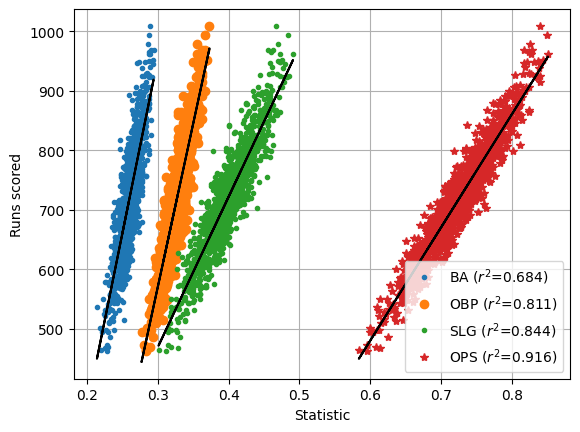

In [134]:
slBA, intBA, r_valBA, p_valBA, ste_errBA = stats.linregress(df.BA,df.RS)
rsqBA = r_valBA**2
slOBP, intOBP, r_valOBP, p_valOBP, ste_errOBP = stats.linregress(df.OBP,df.RS)
rsqOBP = r_valOBP**2
slSLG, intSLG, r_valSLG, p_valSLG, ste_errSLG = stats.linregress(df.SLG,df.RS)
rsqSLG = r_valSLG**2
slOPS, intOPS, r_valOPS, p_valOPS, ste_errOPS = stats.linregress(df.OPS,df.RS)
rsqOPS = r_valOPS**2

plt.plot(df.BA,df.RS,'.',label='BA ($r^2$=%.3f)' %rsqBA)
plt.plot(df.OBP,df.RS,'o',label='OBP ($r^2$=%.3f)' %rsqOBP)
plt.plot(df.SLG,df.RS,'.',label='SLG ($r^2$=%.3f)' %rsqSLG)
plt.plot(df.OPS,df.RS,'*',label='OPS ($r^2$=%.3f)' %rsqOPS)
plt.xlabel('Statistic')
plt.ylabel('Runs scored')
plt.legend(loc='lower right')
plt.grid()

yBA = slBA*df.BA + intBA
plt.plot(df.BA,yBA,'k-')
yOBP = slOBP*df.OBP + intOBP
plt.plot(df.OBP,yOBP, 'k-')
ySLG = slSLG*df.SLG + intSLG
plt.plot(df.SLG,ySLG, 'k-')
yOPS = slOPS*df.OPS + intOPS
plt.plot(df.OPS,yOPS, 'k-')

### OBP, SLG, RS의 3차원 상관관계 그래프

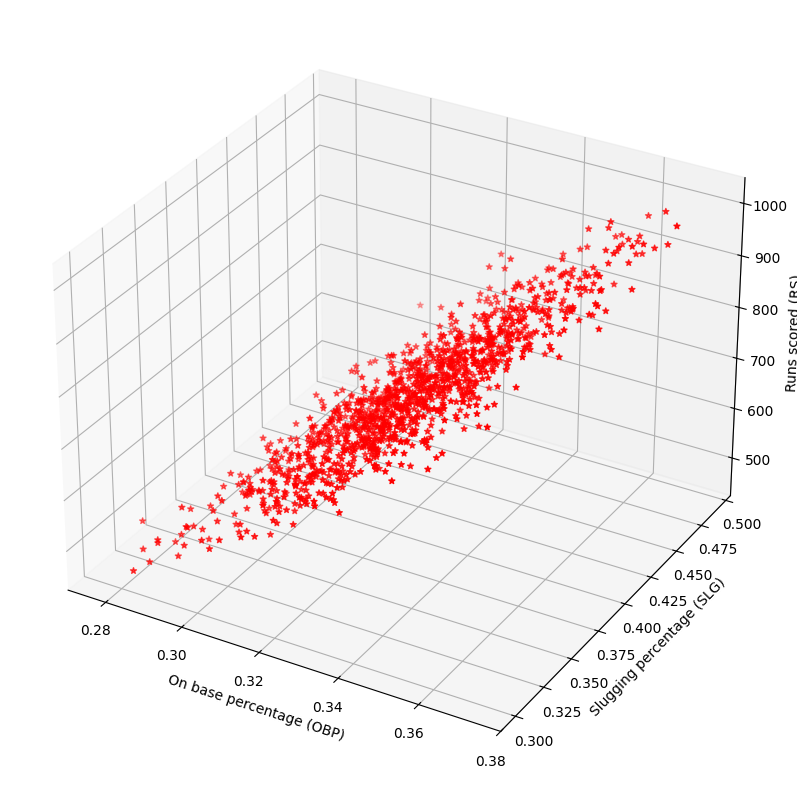

In [135]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.OBP,df.SLG,df.RS,marker='*',color='r')
ax.set_xlabel('On base percentage (OBP)')
ax.set_ylabel('Slugging percentage (SLG)')
ax.set_zlabel('Runs scored (RS)')
x = df.OBP
y = df.SLG
x,y = np.meshgrid(x,y)
z = -803 + 2729*x + 1587*y
# Linear regression for Wins
slWBA, intWBA, r_valWBA, p_valWBA, ste_errWBA = stats.linregress(df.BA,df.W)

# 3. 다중 선형 회귀(Multivariate Linear Regression) 수행

### (1) 반복 횟수, 학습률, 초기 가중치 설정

In [169]:
iterations = 3000000
learning_rate = 0.01
weights = np.array([-1000, 1000, 1000], dtype=np.float64)

### (2) 독립/종속 변수 설정

In [170]:
X1 = df['OBP'].values
X2 = df['SLG'].values
Y = df['RS'].values

X = np.column_stack((X1, X2))

### (3) cost fuction 정의

In [171]:
def cost_function(w, Y):
  w0, w1, w2 = w
  predictions = w0 + X[:, 0] * w1 + X[:, 1] * w2
  errors = predictions - Y
  mse = np.mean(errors**2)
  return mse

In [172]:
def compute_gradient(w, Y):
  w0, w1, w2 = w
  predictions = w0 + X[:, 0] * w1 + X[:, 1] * w2
  errors = predictions - Y

  grad_w0 = np.mean(2 * errors)
  grad_w1 = np.mean(2 * errors * X[:, 0])
  grad_w2 = np.mean(2 * errors * X[:, 1])

  return np.array([grad_w0, grad_w1, grad_w2])

### (4) Gradient Descent 반복 수행

In [173]:
for i in range(iterations):
    gradients = compute_gradient(weights, Y)
    weights -= learning_rate * gradients

    if i % 500000 == 0:
        cost = cost_function(weights, Y)
        print(f"Iteration {i}: Cost {cost:.6f}")

Iteration 0: Cost 936183.334006
Iteration 500000: Cost 666.847522
Iteration 1000000: Cost 638.361880
Iteration 1500000: Cost 631.646960
Iteration 2000000: Cost 630.064052
Iteration 2500000: Cost 629.690914


In [174]:
print('OBP 기울기:', weights[1])
print('SLG 기울기:', weights[2])
print('절편:', weights[0])

OBP 기울기: 2812.8152376783955
SLG 기울기: 1524.3222559462472
절편: -808.5039036845528


### (5) 결정 계수 계산

In [175]:
predictions = weights[0] + X[:, 0] * weights[1] + X[:, 1] * weights[2]

Y_mean = np.mean(Y)
SS_res = np.sum((Y - predictions) ** 2)
SS_tot = np.sum((Y - Y_mean) ** 2)
R_squared = 1 - (SS_res / SS_tot)

print("결정계수 R²:", R_squared)

결정계수 R²: 0.9247941301431282


# 4. 다중 선형 회귀(Multivariate Linear Regression) 수행 - scikit learn 라이브러리 사용

In [176]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
lr = LinearRegression()
lr.fit(X_train, Y_train)

r_square, coef, intercept = lr.score(X_train, Y_train), lr.coef_, lr.intercept_
print('결정계수 R:', r_square)
print('OBP 기울기:', coef[0])
print('SLG 기울기:', coef[1])
print('절편:', intercept)

결정계수 R: 0.9275808277128741
OBP 기울기: 2803.287897731163
SLG 기울기: 1508.6056251666375
절편: -799.4554730543672


# 5. 데이터 & 회귀 직선 시각화 (Python 코드)

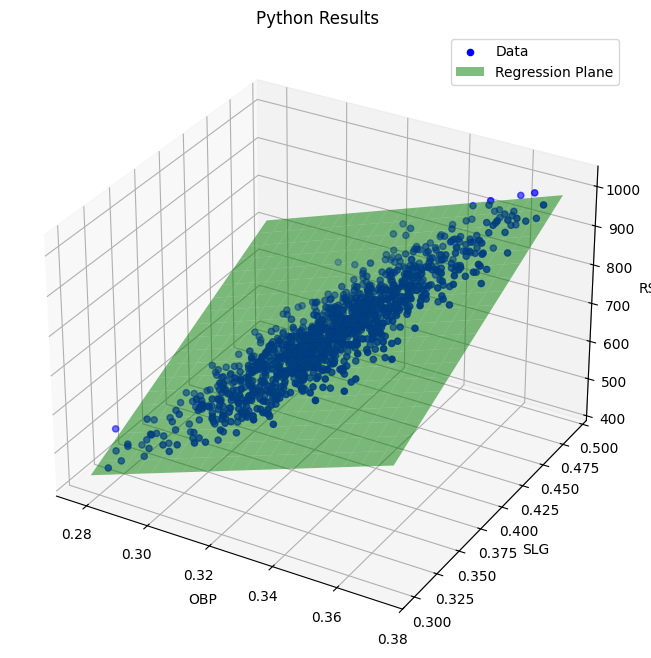

In [177]:
obp_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 20)
slg_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
OBP_grid, SLG_grid = np.meshgrid(obp_range, slg_range)

RS_plane = weights[0] + weights[1] * OBP_grid + weights[2] * SLG_grid

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], Y, color='blue', label='Data')
ax.plot_surface(OBP_grid, SLG_grid, RS_plane, color='green', alpha=0.5, label='Regression Plane')

ax.set_xlabel('OBP')
ax.set_ylabel('SLG')
ax.set_zlabel('RS')
ax.legend()
plt.title("Python Results")
plt.show()

# 6. 데이터 & 회귀 직선 시각화 (MATLAB 코드)

동일한 설정으로 매트랩 코드를 작성한 후 실행했습니다. (파일명: multivariate_linear_regression.m)  

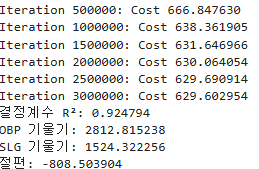

파이썬 코드로 실행해서 얻은 가중치와 값이 동일한 것을 확인할 수 있습니다.

In [178]:
matlab_weights = [-808.503904, 2812.8153238, 1524.322256]

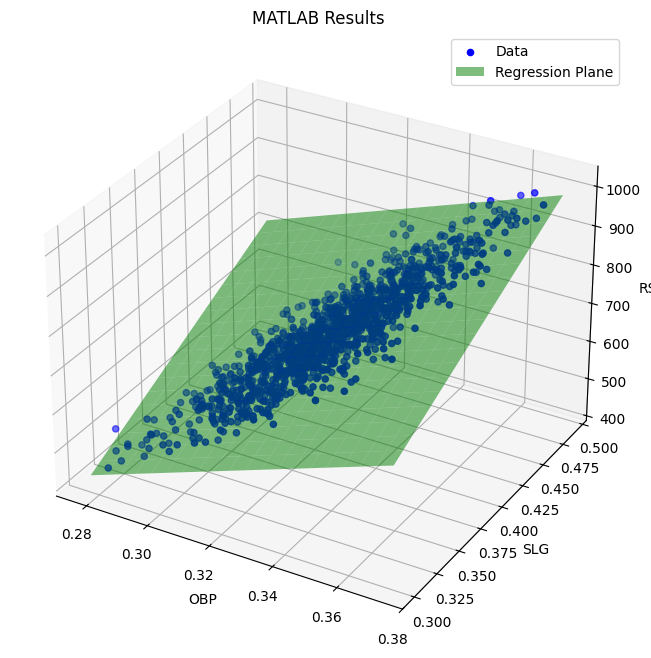

In [179]:
obp_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 20)
slg_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
OBP_grid, SLG_grid = np.meshgrid(obp_range, slg_range)

RS_plane = matlab_weights[0] + matlab_weights[1] * OBP_grid + matlab_weights[2] * SLG_grid

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], Y, color='blue', label='Data')
ax.plot_surface(OBP_grid, SLG_grid, RS_plane, color='green', alpha=0.5, label='Regression Plane')

ax.set_xlabel('OBP')
ax.set_ylabel('SLG')
ax.set_zlabel('RS')
ax.legend()
plt.title("MATLAB Results")
plt.show()